<a href="https://colab.research.google.com/github/fbeilstein/neural_networks/blob/master/lecture_2_nn_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Visualization Helper

try:
  from torchview import draw_graph
except:
  !pip install -q torchmetrics torchinfo torchview
finally:
  from torchview import draw_graph

import re
def recolor_nodes(graph, layer_keyword, new_color):
  for i, node in enumerate(graph.visual_graph.body):
    if not layer_keyword in node:
      continue
    if "fillcolor=" in node:
      graph.visual_graph.body[i] = re.sub(
          r'fillcolor=[^,\]]+',
          f'fillcolor={new_color}',
          node
      )
    else:
      graph.visual_graph.body[i] = node.replace(
          "]", f", fillcolor={new_color}]"
      )

def restyle_graph(graph):
  recolor_nodes(graph, "Dropout", "gray")
  recolor_nodes(graph, "MaxPool", "red")
  recolor_nodes(graph, "Linear", "lightblue")
  recolor_nodes(graph, "ReLU", "yellow")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 26.2 MB/s eta 0:00:00


#LeNet

* Developed by Yann LeCun et al. in 1998.

* One of the first successful CNNs, applied to handwritten digit recognition (MNIST).

* Paved the way for modern deep learning in computer vision.

-----

* Uses tanh activation (ReLU was not yet popular).
* Uses average pooling, not max pooling (which became popular later).
* No Dropout or BatchNorm. These techniques didn't exist at the time. LeNet-5 is much shallower and simpler.

-----

* CNN structure idea: alternating convolution + pooling.

* Weight sharing: dramatically reduces number of parameters vs fully connected layers.

* Local receptive fields: how neurons look only at parts of the image.

* Low parameter count: around 60k parameters—tiny by modern standards!

* Bias-variance balance: good example of a simple model that avoids overfitting by design.

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/lenet_architecture.png" width='550'>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. LeNet-5 architecture
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 28x28 -> 24x24
    self.pool1 = nn.AvgPool2d(kernel_size=2)      # 24x24 -> 12x12
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 12x12 -> 8x8
    self.pool2 = nn.AvgPool2d(kernel_size=2)      # 8x8 -> 4x4
    self.conv3 = nn.Conv2d(16, 120, kernel_size=4)  # 4x4 -> 1x1

    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

  def forward(self, x):
    x = torch.tanh(self.conv1(x))
    x = self.pool1(x)
    x = torch.tanh(self.conv2(x))
    x = self.pool2(x)
    x = torch.tanh(self.conv3(x))
    x = x.view(-1, 120)
    x = torch.tanh(self.fc1(x))
    x = self.fc2(x)
    return x


In [ ]:
# 2. Prepare data
transform = transforms.Compose([
  transforms.Resize((28, 28)),  # Just to be sure
  transforms.ToTensor()
])

train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000, shuffle=False)

# 3. Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop
for epoch in range(5):
  model.train()
  total_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]


Epoch 1, Loss: 294.13
Epoch 2, Loss: 96.04
Epoch 3, Loss: 66.10
Epoch 4, Loss: 50.09
Epoch 5, Loss: 40.33


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.45%


#AlexNet

* Breakthrough: AlexNet won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012 by a huge margin.

* Popularized CNNs: It showed that convolutional neural networks trained on GPUs could achieve state-of-the-art results on real-world large-scale datasets.

* Catalyst for Deep Learning: It essentially started the current deep learning boom in computer vision.

--------

**New Features/Ideas**

* Deep Architecture
* ReLU Activation	instead of tanh/sigmoid for faster convergence
* Introduced dropout to prevent overfitting in fully connected layers
* Used overlapping $3\times 3$ pooling (stride 2) instead of $2 \times 2$ non-overlapping
* Used data augmentation techniques like image translation and reflection to expand dataset
* Trained on 2 GPUs, splitting the model across them (early model parallelism)
* Used Local Response Normalization (LRN) to encourage lateral inhibition (now less common)

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/alexnet_architecture.png" width='550'>

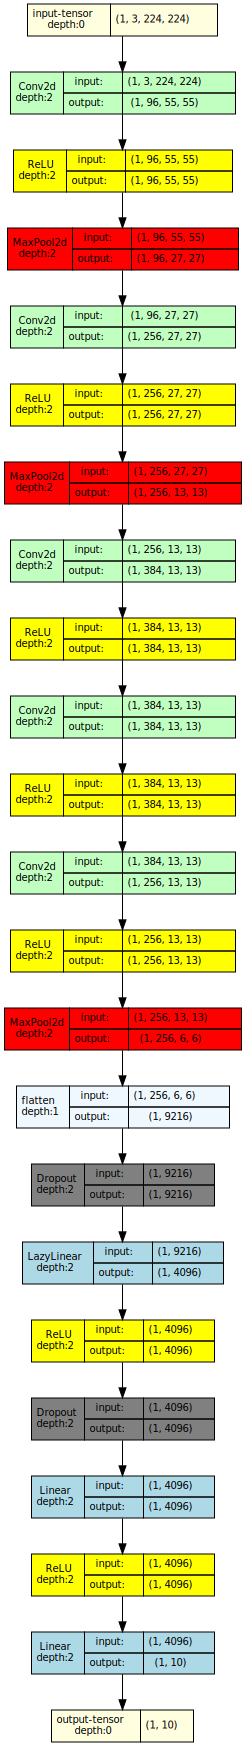

In [ ]:
#@title AlexNet architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Define AlexNet for CIFAR-10 (input 3x32x32 instead of 224x224)
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # CIFAR-10: input 32x32, here causes strong shrink
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(96, 256, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(256, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.LazyLinear(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)


model_graph = draw_graph(model, input_size=[1,3,224,224], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

#Autoencoder

In [ ]:
#@title Manual PCA
%%html
<iframe title="Demo"
        src="https://fbeilstein.github.io/machine_learning/lecture_12_principal_component_analysis/demo_pca.html"
        width="800" height="450"
        marginwidth="0" marginheight="0" frameborder="0"
        scrolling="no">
Your browser does not support IFrames.
</iframe>


In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/autoencoder_architecture.webp" height=400>


**Autoencoder**

* Neural network trained to reconstruct input from a compressed internal representation.
* Consists of:
  - Encoder: Maps input → latent space.
  - Decoder: Reconstructs input from latent code.
* Unsupervised learning: No labels needed during training.

--------

**Architecture**
* Symmetric structure: Encoder and decoder mirror each other.
* Common layers: Fully connected (dense), Convolutional (for images)
* Bottleneck layer: Represents compressed features.

-------

**Applications**
* Dimensionality reduction (alternative to PCA)
* Denoising: Removes noise from corrupted input
* Anomaly detection: Poor reconstruction signals anomaly
* Image compression and synthesis

**Denoising Autoencoders**
* Trained with noisy input but clean target.
* Learns to map noisy → clean data.
* Helps the model extract robust features.

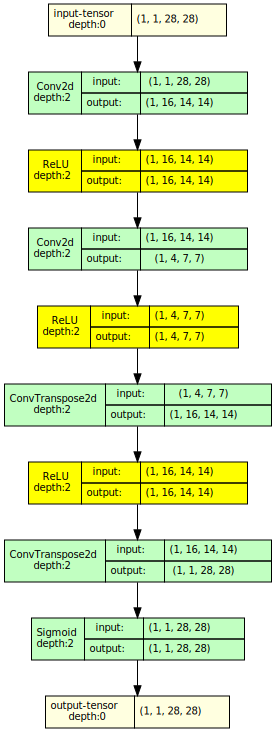

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
      nn.ReLU(),
      nn.Conv2d(16, 4, 3, stride=2, padding=1),  # 4x7x7
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(4, 16, 3, stride=2, output_padding=1, padding=1),  # 16x14x14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  # 1x28x28
        nn.Sigmoid()
      )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

model_graph = draw_graph(model, input_size=[1,1,28,28], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
class NoisyMNIST(Dataset):
  def __init__(self, train=True):
    self.data = datasets.MNIST(root='./data', train=train, download=True,
                                transform=transforms.ToTensor())

  def __getitem__(self, index):
    img, label = self.data[index]
    noisy_img = img + 0.5 * torch.randn_like(img)  # add Gaussian noise
    noisy_img = torch.clip(noisy_img, 0., 1.)
    return noisy_img, img

  def __len__(self):
    return len(self.data)


train_loader = DataLoader(NoisyMNIST(train=True), batch_size=128, shuffle=True)
test_loader = DataLoader(NoisyMNIST(train=False), batch_size=10, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
  model.train()
  loss_sum = 0
  for noisy, clean in train_loader:
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy)
    loss = criterion(output, clean)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_sum += loss.item()
  print(f"Epoch {epoch+1}, Loss: {loss_sum / len(train_loader):.4f}")


Epoch 1, Loss: 0.0595
Epoch 2, Loss: 0.0190
Epoch 3, Loss: 0.0177
Epoch 4, Loss: 0.0171
Epoch 5, Loss: 0.0164


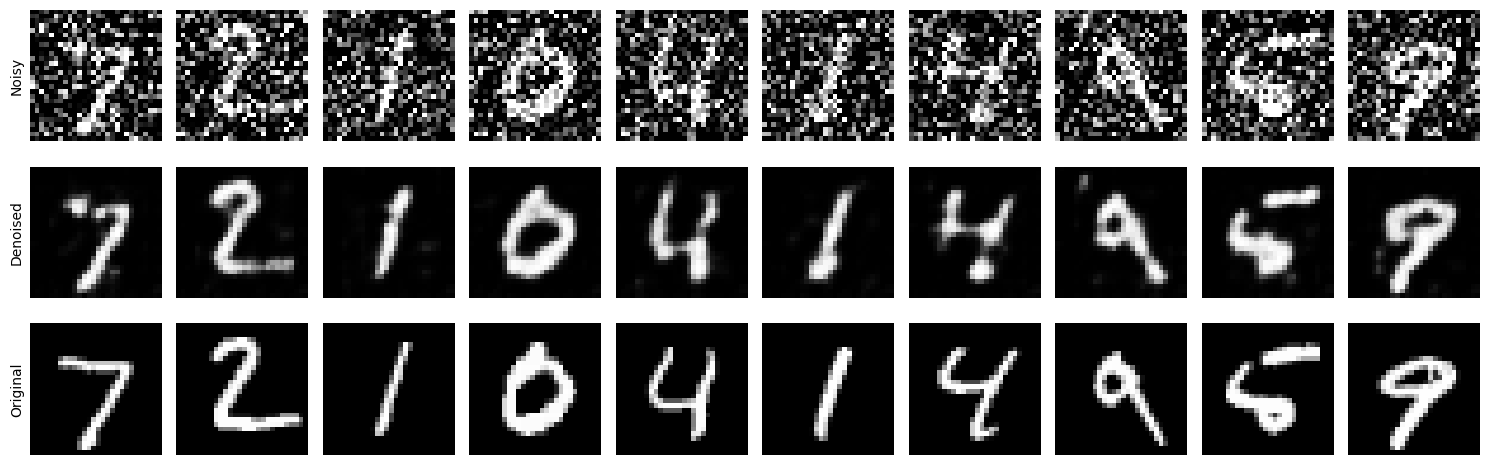

In [ ]:
model.eval()
noisy_imgs, clean_imgs = next(iter(test_loader))
with torch.no_grad():
  noisy_imgs = noisy_imgs.to(device)
  reconstructed = model(noisy_imgs).cpu()

# Plotting
def show_images(noisy, reconstructed, original):
  fig, axs = plt.subplots(3, 10, figsize=(15, 5))
  for i in range(10):
    axs[0, i].imshow(noisy[i][0], cmap='gray')
    axs[1, i].imshow(reconstructed[i][0], cmap='gray')
    axs[2, i].imshow(original[i][0], cmap='gray')
    for ax in axs[:, i]:
      #ax.axis('off')
      ax.spines[:].set_visible(False)
      ax.set_xticks([])
      ax.set_yticks([])
  axs[0, 0].set_ylabel("Noisy")
  axs[1, 0].set_ylabel("Denoised")
  axs[2, 0].set_ylabel("Original")
  plt.tight_layout()
  plt.show()

show_images(noisy_imgs.cpu(), reconstructed, clean_imgs)


#Variational Autoencoder (VAE)

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE1.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE2.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE3.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE4.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE5.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE6.webp" width=750>
`])

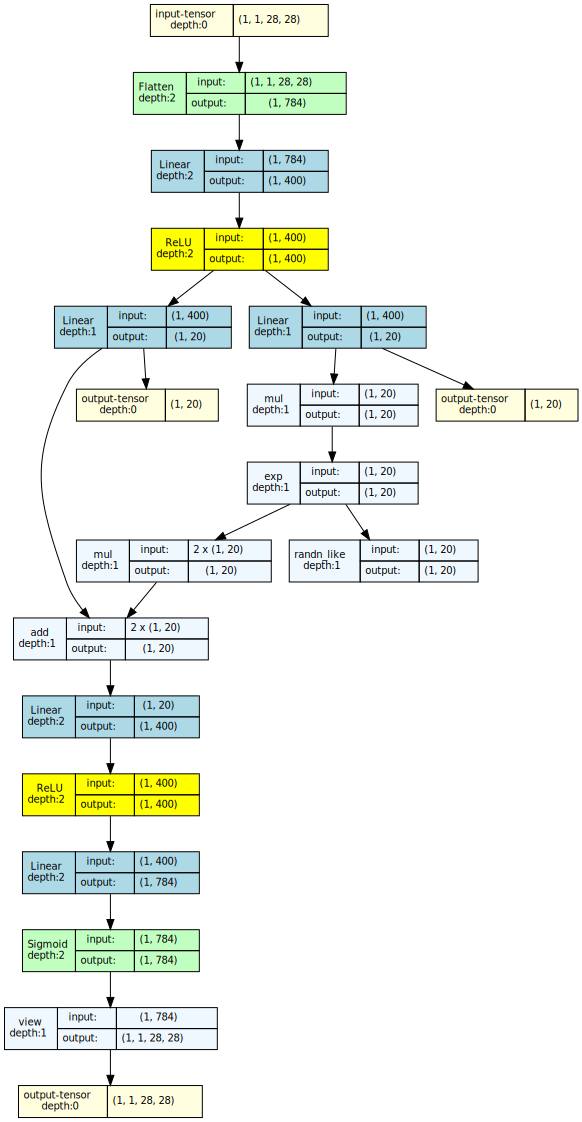

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class VAE(nn.Module):
  def __init__(self, latent_dim=20):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 400),
      nn.ReLU(),
    )
    self.fc_mu = nn.Linear(400, latent_dim)
    self.fc_logvar = nn.Linear(400, latent_dim)

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 400),
      nn.ReLU(),
      nn.Linear(400, 28*28),
      nn.Sigmoid()  # output in [0,1]
    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std  # reparameterization trick

  def forward(self, x):
    x = self.encoder(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    z = self.reparameterize(mu, logvar)
    recon = self.decoder(z)
    return recon.view(-1, 1, 28, 28), mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)

model_graph = draw_graph(model, input_size=[1,1,28,28], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_div

for epoch in range(1, 11):
  model.train()
  total_loss = 0
  for x, _ in train_loader:
    x = x.to(device)
    recon_x, mu, logvar = model(x)
    loss = loss_function(recon_x, x, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader.dataset):.2f}")

Epoch 1, Loss: 164.21
Epoch 2, Loss: 121.29
Epoch 3, Loss: 114.59
Epoch 4, Loss: 111.66
Epoch 5, Loss: 109.97
Epoch 6, Loss: 108.72
Epoch 7, Loss: 107.86
Epoch 8, Loss: 107.24
Epoch 9, Loss: 106.67
Epoch 10, Loss: 106.27


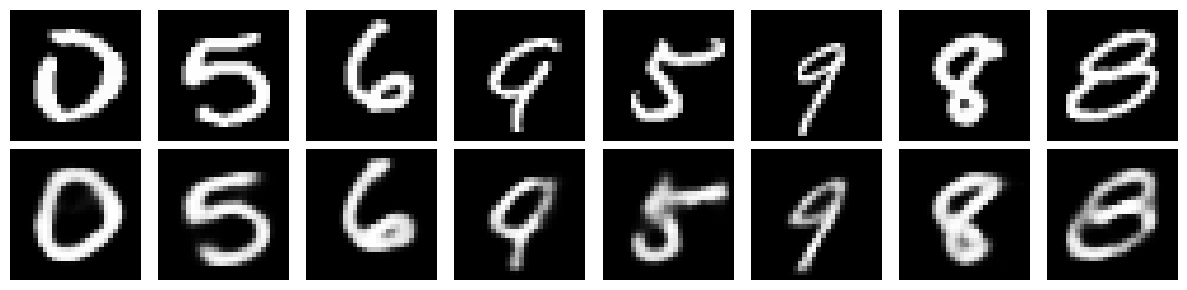

In [ ]:
model.eval()
with torch.no_grad():
  x, _ = next(iter(train_loader))
  x = x.to(device)
  recon_x, m, v = model(x)

  fig, axs = plt.subplots(2, 8, figsize=(12, 3))
  for i in range(8):
    axs[0, i].imshow(x[i].cpu().squeeze(), cmap="gray")
    axs[1, i].imshow(recon_x[i].cpu().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].axis("off")
  axs[0, 0].set_ylabel("Input")
  axs[1, 0].set_ylabel("Recon")
  plt.tight_layout()
  plt.show()

#ResNet

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/Resnet18_architecture.svg" width=750>


**ResNet (Residual Network)**

* Deep neural network designed to ease training of very deep architectures.
* Key idea: Residual connections (skip connections) allow layers to learn only the difference (residual) from identity mapping.

**Architecture**

* Building block: Residual block
* Input → Convolution(s) → Output
* Plus a shortcut connection that adds the original input back to the output.

**Types of residual blocks:**

* Basic block (used in ResNet-18, ResNet-34): two $3\times 3$ convolutions + skip connection.
* Bottleneck block (used in deeper ResNets): $1\times 1$ conv (reduce dims) → $3\times 3$ conv → $1\times 1$ conv (restore dims) + skip.
* If input/output dimensions differ, shortcut uses $1\times 1$ conv to match shapes.
* Network is a stack of residual blocks with pooling at start and global average pooling at end → classifier.

------

**Why Residual Connections Help**

* Deep plain networks suffer from vanishing gradients and degradation problem (accuracy worsens as depth increases).
* Skip connections let gradients flow directly through identity paths.
* Model can easily learn identity mapping if deeper layers are unnecessary → prevents performance drop.

-------

**Applications**

* Image classification (ImageNet benchmark winner, 2015).
* Backbone for many CV architectures: object detection (Faster R-CNN), segmentation (Mask R-CNN, U-Net variants).
* Adapted to NLP, speech, and other domains where deep models are useful.

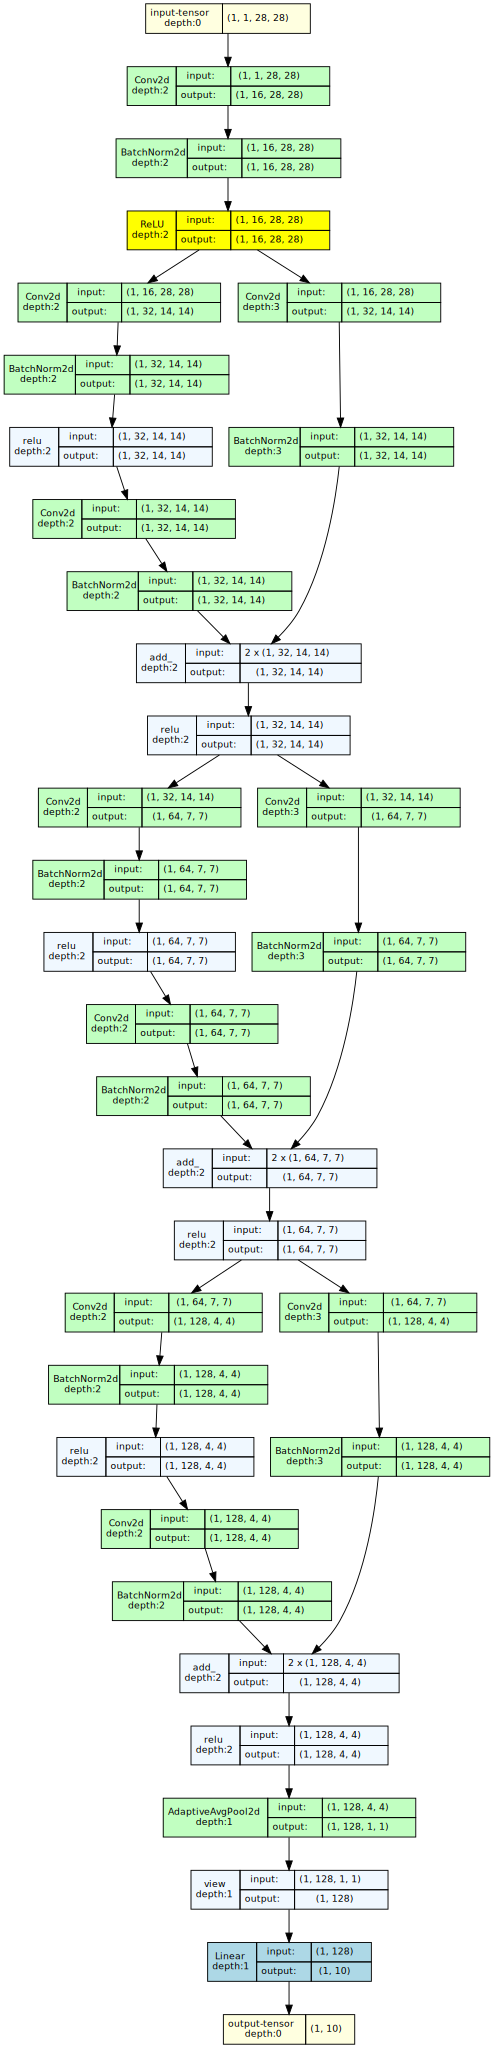

In [ ]:
# ResNet (ResNet18-like) for MNIST classification

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                            stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1,
                  stride=stride, bias=False),
        nn.BatchNorm2d(out_channels))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    return F.relu(out)

class ResNetSmall(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.init_conv = nn.Sequential(
      nn.Conv2d(1, 16, 3, 1, 1),
      nn.BatchNorm2d(16),
      nn.ReLU())

    self.layer1 = BasicBlock(16, 32, stride=2)
    self.layer2 = BasicBlock(32, 64, stride=2)
    self.layer3 = BasicBlock(64, 128, stride=2)

    self.pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.init_conv(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)

model_graph = draw_graph(model, input_size=[1,1,28,28], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Keep it short for demo
  model.train()
  running_loss = 0.0
  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]


Epoch 1, Loss: 0.1276
Epoch 2, Loss: 0.0361
Epoch 3, Loss: 0.0262
Epoch 4, Loss: 0.0190
Epoch 5, Loss: 0.0183
Accuracy on test set: 99.16%


#U-Net

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/unet_architecture.png" width=550>


Neural network architecture designed for **image segmentation**, especially in biomedical imaging.

**Key idea:** Encoder-decoder structure with skip connections → combines global context (from encoder) with fine localization (from decoder).


---


**Architecture**

* Encoder (contracting path)
  - Each step halves spatial resolution, doubles feature channels
  - Captures context (what is in the image).
* Decoder (expanding path)
  - Up-convolutions (transpose conv / bilinear upsampling + conv)
  - Each step doubles resolution, halves feature channels
  - Restores spatial detail (where objects are).
* Skip connections
  - Feature maps from encoder are concatenated with corresponding decoder layers.
  - Preserves fine-grained spatial information lost during pooling.
* Final layer
  - maps decoder features to segmentation mask (per-pixel class probabilities).

**Why U-Net Works**

* Encoders extract hierarchical features (shapes, textures, semantics).
* Decoders alone would be blurry → skip connections inject high-resolution details.
* Allows precise pixel-level predictions with relatively few training images.


**Applications**

* Biomedical imaging (cell/nucleus segmentation, tumor detection).
* Satellite / aerial imagery (roads, buildings, land cover).
* General semantic segmentation (objects, backgrounds).
* Variants adapted for 3D volumes (medical CT/MRI), attention mechanisms, and multi-task learning.

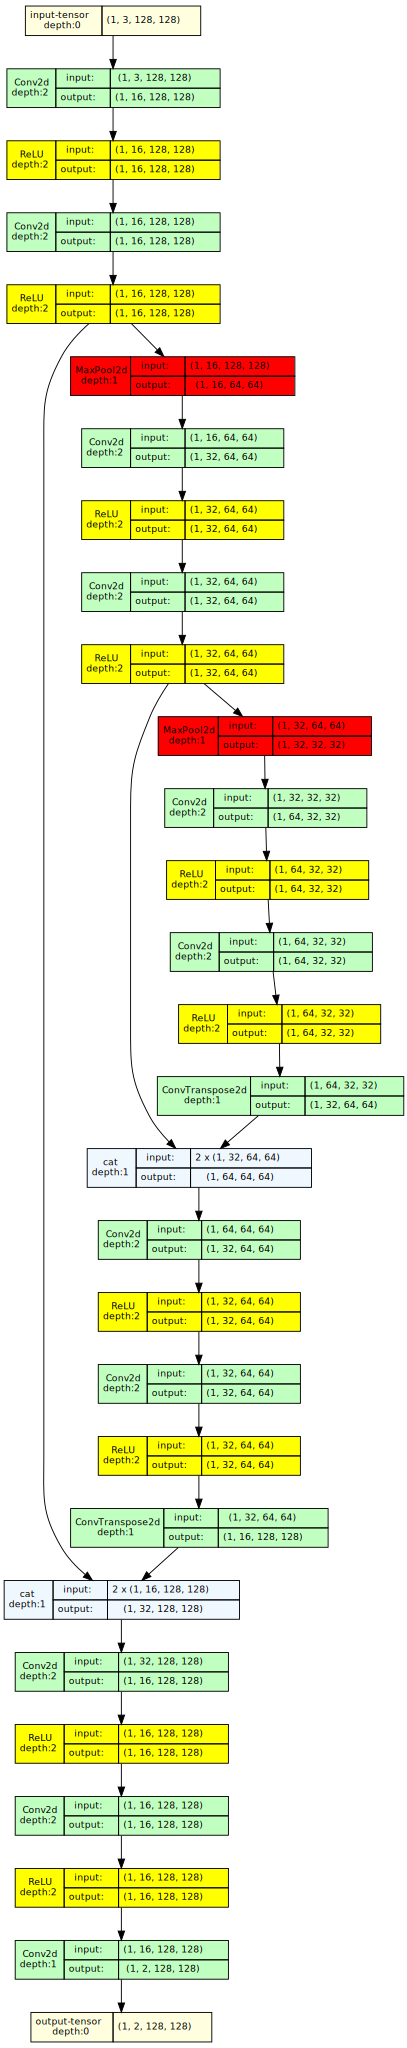

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    def C(in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU()
        )
    self.enc1 = C(3, 16)
    self.enc2 = C(16, 32)
    self.enc3 = C(32, 64)
    self.pool = nn.MaxPool2d(2)
    self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
    self.dec2 = C(64, 32)
    self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
    self.dec1 = C(32, 16)
    self.outc = nn.Conv2d(16, 2, 1)

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(self.pool(e1))
    e3 = self.enc3(self.pool(e2))
    d2 = self.up2(e3)
    d2 = self.dec2(torch.cat([d2, e2], dim=1))
    d1 = self.up1(d2)
    d1 = self.dec1(torch.cat([d1, e1], dim=1))
    return self.outc(d1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

model_graph = draw_graph(model, input_size=[1,3,128,128], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [18]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os

# Download Oxford-IIIT Pet dataset
dataset = torchvision.datasets.OxfordIIITPet(
  root=".",
  split="trainval",
  target_types="segmentation",
  download=True,
)

# Filter cats only
cat_classes = ["Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair",
               "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll",
               "Russian_Blue", "Siamese", "Sphynx"]

cat_indices = [i for i, c in enumerate(dataset._labels) if dataset.classes[c] in cat_classes]

class CatSegmentation(Dataset):
  def __init__(self, dataset, indices, size=128):
    self.dataset = dataset
    self.indices = indices
    self.t_img = T.Compose([
      T.Resize((size,size)),
      T.ToTensor()
    ])
    self.t_mask = T.Compose([
      T.Resize((size,size), interpolation=T.InterpolationMode.NEAREST),
      T.PILToTensor()
    ])

  def preprocess_mask(self, mask_old):
      mask = mask_old.clone().float()
      mask[mask_old == 1] = 1.0   # background
      mask[mask_old == 2] = 0.0   # border
      mask[mask_old == 3] = 0.5   # cat
      return mask

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    img, mask = self.dataset[self.indices[idx]]

    return self.t_img(img), self.preprocess_mask(self.t_mask(mask)[0])

cats = CatSegmentation(dataset, cat_indices, size=64)
train_loader = DataLoader(cats, batch_size=16, shuffle=True)


Epoch 1, loss 0.7810
Epoch 2, loss 0.6118
Epoch 3, loss 0.5541
Epoch 4, loss 0.5321
Epoch 5, loss 0.5039
Epoch 6, loss 0.4307
Epoch 7, loss 0.4877
Epoch 8, loss 0.4957
Epoch 9, loss 0.5069
Epoch 10, loss 0.5496
Epoch 11, loss 0.4306
Epoch 12, loss 0.3950
Epoch 13, loss 0.3777
Epoch 14, loss 0.4245
Epoch 15, loss 0.3430
Epoch 16, loss 0.3587
Epoch 17, loss 0.4259
Epoch 18, loss 0.4674
Epoch 19, loss 0.3575
Epoch 20, loss 0.3421
Epoch 21, loss 0.3546
Epoch 22, loss 0.3803
Epoch 23, loss 0.4273
Epoch 24, loss 0.3418
Epoch 25, loss 0.3572
Epoch 26, loss 0.3427
Epoch 27, loss 0.3172
Epoch 28, loss 0.4149
Epoch 29, loss 0.3659
Epoch 30, loss 0.3556
Epoch 31, loss 0.2858
Epoch 32, loss 0.3149
Epoch 33, loss 0.3452
Epoch 34, loss 0.3037
Epoch 35, loss 0.3213
Epoch 36, loss 0.3273
Epoch 37, loss 0.3305
Epoch 38, loss 0.3314
Epoch 39, loss 0.2828
Epoch 40, loss 0.2821
Epoch 41, loss 0.2168
Epoch 42, loss 0.2407
Epoch 43, loss 0.2412
Epoch 44, loss 0.2988
Epoch 45, loss 0.3354
Epoch 46, loss 0.26

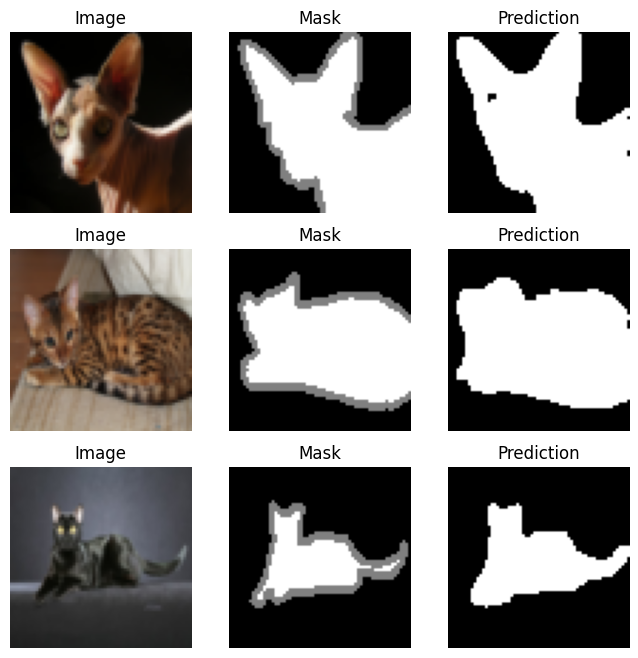

In [19]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
  for imgs, masks in train_loader:
    imgs, masks = imgs.to(device), masks.to(device)
    logits = model(imgs)
    loss = criterion(logits, (masks > 0.1).long())
    opt.zero_grad()
    loss.backward()
    opt.step()
  print(f"Epoch {epoch+1}, loss {loss.item():.4f}")


model.eval()
imgs, masks = next(iter(train_loader))
with torch.no_grad():
  preds = model(imgs.to(device)).argmax(1).cpu()

fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(3):
  axs[i,0].imshow(imgs[i].permute(1,2,0))
  axs[i,0].set_title("Image")
  axs[i,1].imshow(masks[i], cmap="gray")
  axs[i,1].set_title("Mask")
  axs[i,2].imshow(preds[i], cmap="gray")
  axs[i,2].set_title("Prediction")
  for j in range(3): axs[i,j].axis("off")
plt.show()

#VGG-16

In [20]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/vgg16_architecture.png" width=550>


#FCN-32

In [21]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/fcn32_architecture.png" width=550>


#GAN

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/GAN1.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/GAN2.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/GAN3.webp" width=750>
`])

for details see "*Generative Adversarial Nets*" by Ian J. Goodfellow et all.


**for** number of training iterations **do**

$~~~~$**for** $k$ steps **do**

$~~~~$$~~~~$• Sample minibatch of $m$ noise samples $\{z^{(1)},\dots,z^{(m)}\}$ from noise prior $p_g(z)$.

$~~~~$$~~~~$• Sample minibatch of $m$ examples $\{x^{(1)},\dots,x^{(m)}\}$ from data generating distribution $p_\text{data}(x)$.

$~~~~$$~~~~$• Update the discriminator by ascending its stochastic gradient:
$$
\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^m \left[ \ln D (x^{(i)}) + \ln \left( 1 - D(G(z^{(i)})) \right)\right]
$$
$~~~~$**end for**

$~~~~$• Sample minibatch of $m$ noise samples $\{z^{(1)},\dots,z^{(m)}\}$ from noise prior $p_g(z)$.

$~~~~$• Update the generator by descending its stochastic gradient:
$$
\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \ln \left( 1 - D(G(z^{(i)})) \right)
$$

**end for**

$D$ - probability that data is genuine.

For perfect discriminator $D(x) = 1$ and $D(G(z)) = 0$. In this case $\ln D + \ln(1-D(G)) = 0$ while for any other case $< 0$. **Discriminator maximizes loss**.

$G$ - would be perfect if $D(G) = 1$, thus loss would be $-\infty$. **Generator minimizes loss**

$$
\min_G \max_D \frac{1}{m} \sum_{i=1}^m \left[ \ln D (x^{(i)}) + \ln \left( 1 - D(G(z^{(i)})) \right)\right]
$$

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Inter-house_sports-_tug_of_war.jpg/640px-Inter-house_sports-_tug_of_war.jpg)

It can be proven that balance is acieved when $D(x) = D(G(z)) = 1/2$, that basically means genuine and generated data are indistinguishable.

#RNN

#LSTM

#NERF

#Diffusion NN

#Transformer